# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [153]:
%matplotlib inline

from astropy.table import Table
tab = Table.read('../../homework/07/KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
539.5118864718097,5225.43359375,4.891888618469238,6
539.5323205971945,5233.111328125,4.892074108123779,6
539.5527548221144,5221.17333984375,4.891964435577393,6
539.573189147035,5220.09521484375,4.891523361206055,6
539.5936232714812,5222.14208984375,4.893854141235352,6
539.6140574957026,5224.57958984375,4.893648147583008,6
539.6344918194518,5223.78564453125,4.894421100616455,6


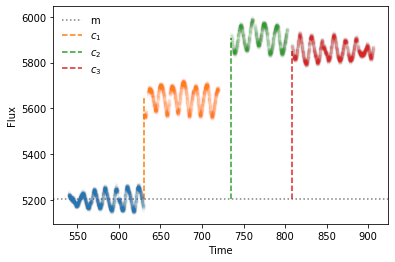

In [154]:
import numpy as np
import matplotlib.pyplot as plt

qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)


### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

In [334]:
import george
from george import kernels

## input the dummies for parameters first
## expsine2
kernel1 = kernels.ExpSine2Kernel(gamma=1.0, log_period=1.0)
## expsq
kernel2 = kernels.ExpSquaredKernel(metric=1.0)

## combine the kernels with a constant amplitude
gpkernel = A*kernel1*kernel2

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

Text(0.5, 1.0, 'Simple model with initial guesses')

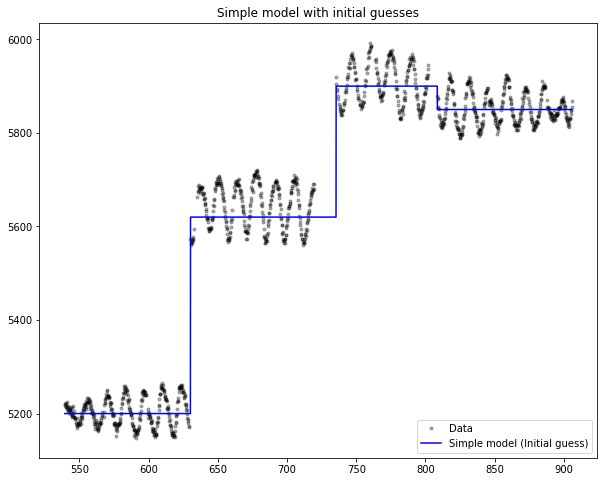

In [335]:
from george.modeling import Model

## make the model without GP
## timestamps that divides each cycle: 630, 735, 808

class Simple_Model(Model):
    parameter_names = ("m", "c1", "c2", "c3")

    def get_value(self, t):
        qs = sorted(np.unique(tab['quarter']))
        out = np.zeros(len(t))    
        out[:] = self.m
        for i in range(len(qs)-1):
            qind = tab['quarter']==qs[i+1]
            tind = np.where(t>np.min(tab['time'][qind]))[0]
            if i ==0: out[tind] = self.m+self.c1
            if i ==1: out[tind] = self.m+self.c2
            if i ==2: out[tind] = self.m+self.c3
        
        return out;

m0 = 5200
c1 = 420
c2 = 700
c3 = 650

plt.figure(figsize=(10,8))
tt = tab['time']
qq = tab['quarter']
ff = tab['flux']
ee = tab['error']
yy = Simple_Model(m=m0,c1=c1,c2=c2,c3=c3).get_value(tt)
plt.plot(tt[::10],ff[::10],'k.',alpha=0.3,label='Data')
plt.plot(tt,yy,'b-',label='Simple model (Initial guess)')
plt.legend(loc='lower right')
plt.title('Simple model with initial guesses')

In [336]:
## use scipy to optimize the initial guess first
import scipy.optimize as so

def Simple_Model_chisq(p0,tt,ff):
    m,c1,c2,c3=p0
    model = Simple_Model(m=m,c1=c1,c2=c2,c3=c3).get_value(tt)
    chisq = np.sum((ff-model)**2/ee**2)
    return chisq

res = so.minimize(Simple_Model_chisq, [m0,c1,c2,c3], args=(tt, ff))
print('Initial guesses for m, c1, c2, c3 (with scipy.optimize):', res.x)

Initial guesses for m, c1, c2, c3 (with scipy.optimize): [5203.860072    439.99915401  701.9904014   648.24435268]


Text(0.5, 1.0, 'Simple model with scipy optimize')

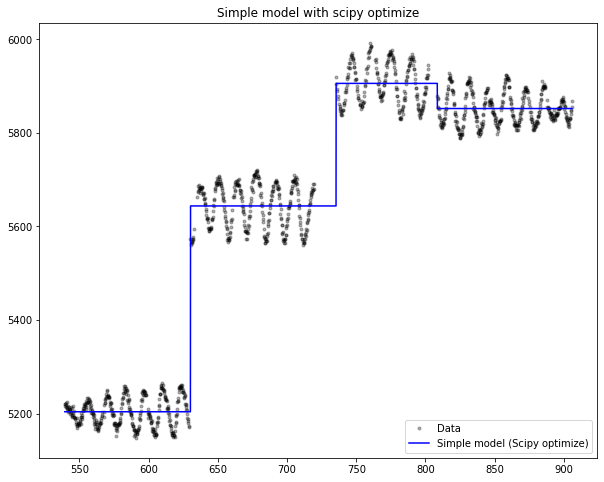

In [337]:
plt.figure(figsize=(10,8))
tt = tab['time']
qq = tab['quarter']
ff = tab['flux']
ee = tab['error']
yy = Simple_Model(m=res.x[0],c1=res.x[1],c2=res.x[2],c3=res.x[3]).get_value(tt)
plt.plot(tt[::10],ff[::10],'k.',alpha=0.3,label='Data')
plt.plot(tt,yy,'b-',label='Simple model (Scipy optimize)')
plt.legend(loc='lower right')
plt.title('Simple model with scipy optimize')

In [338]:
## make the GP model

## initial guesses
A = 10.
gamma1=0.1
log_period=1.0
lamb=1.0
m0,c1,c2,c3 = res.x

kernel1 = kernels.ExpSine2Kernel(gamma=gamma1, log_period=log_period)
kernel2 = kernels.ExpSquaredKernel(metric=lamb)

gpkernel = A*kernel1*kernel2

gp = george.GP(gpkernel, mean=Simple_Model(m=res.x[0],c1=res.x[1],c2=res.x[2],c3=res.x[3]))
gp.compute(tt[::10], ee[::10])

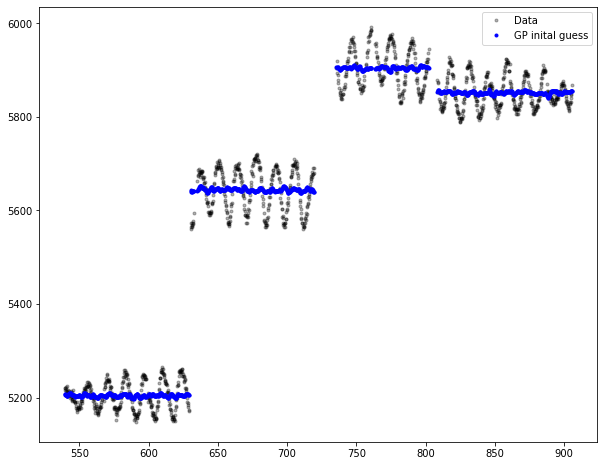

In [339]:
#print (gp.sample(t=tt[::10]))
plt.figure(figsize=(10,8))
plt.plot(tt[::10],ff[::10],'k.',alpha=0.3,label='Data')
plt.plot(tt[::10],gp.sample(t=tt[::10]),'b.',label='GP inital guess')
plt.legend()

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

In [340]:
import scipy.stats as st

def lnprob(p):
    
    gp.set_parameter_vector(p)
    #print (p)
    prior = 0
    
    if  p[0]>5000 and p[0]<6000 and p[1]>100 and p[1]<600 and p[2]>300 and p[2]<1000 and p[3]>300 and p[3]<1000 and p[4]>0 and p[4]<1000. and p[5]>0 and p[5]<1 and p[6]>-10 and p[6]<10 and p[7]>-10 and p[7]<10:
    #if  1==1:
        p_m0 = np.log(st.norm.pdf(p[0], loc=res.x[0], scale=res.x[0]/10.))
        p_c1 = np.log(st.norm.pdf(p[1], loc=res.x[1], scale=res.x[1]/10.))
        p_c2 = np.log(st.norm.pdf(p[2], loc=res.x[2], scale=res.x[2]/10.))
        p_c3 = np.log(st.norm.pdf(p[3], loc=res.x[3], scale=res.x[3]/10.))
        p_a = np.log(st.norm.pdf(p[4], loc=A, scale=A/10.))
        p_g = np.log(st.norm.pdf(p[5], loc=gamma1, scale=gamma1/10.))
        p_p = np.log(st.norm.pdf(p[6], loc=log_period, scale=log_period/10.))
        p_l = np.log(st.norm.pdf(p[7], loc=lamb, scale=lamb/10.))
        prior = p_m0+p_c1+p_c2+p_c3+p_a+p_g+p_p+p_l
    else:
        return -np.inf
            
    #print('loglike',gp.log_likelihood(ff[::10], quiet=True))
    #print ('prior',prior)
    return gp.log_likelihood(ff[::10], quiet=True)+prior

print(lnprob([m0,c1,c2,c3,A,gamma1,log_period,lamb]))



-5771.859699570791


### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [341]:
import emcee
import corner

initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running first burn-in...")
p0 = initial + 1e-6 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)
burn1 = np.copy(sampler)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-6 * np.random.randn(nwalkers, ndim)
sampler.reset()

p0, _, _ = sampler.run_mcmc(p0, 500)
burn2 = np.copy(sampler)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000);

Running first burn-in...
Running second burn-in...
Running production...


### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 

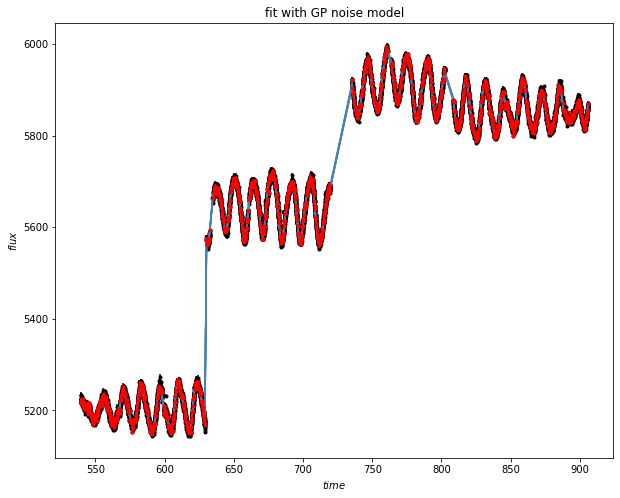

In [342]:
plt.figure(figsize=(10,8))
plt.errorbar(tt[::10], ff[::10], yerr=ee[::10], fmt=".r", capsize=0)
plt.errorbar(tt, ff, yerr=ee, fmt=".k", capsize=0,zorder=-100)

#plt.errorbar(tt[1::10], ff[1::10], yerr=ee[1::10], fmt=".r", capsize=0)


# The positions where the prediction should be computed.
x = np.linspace(550, 920, len(tt[::10]))

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.sample_conditional(ff[::10],tt[::10])
    plt.plot(tt[::10], mu, color="#4682b4", alpha=0.3)

plt.ylabel(r"$flux$")
plt.xlabel(r"$time$")
#pl.xlim(-5, 5)
plt.title("fit with GP noise model");

Text(0.5, 0.98, 'Fitting results for the mean function')

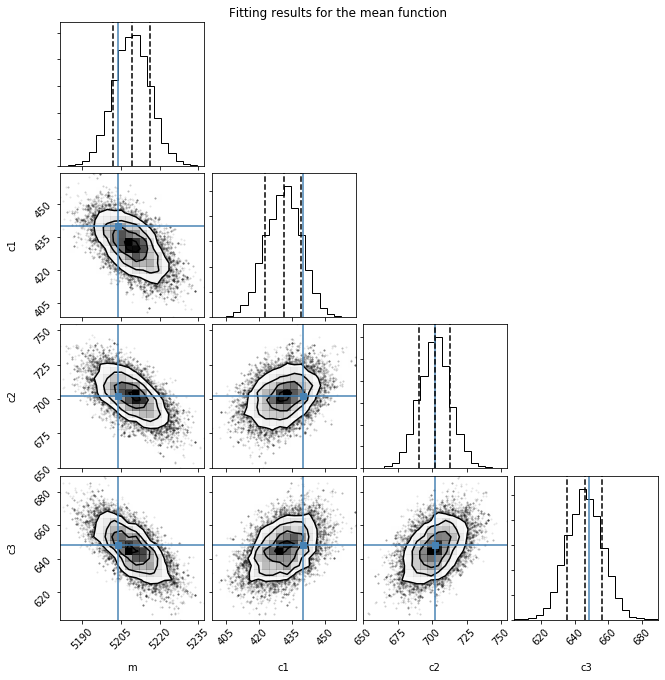

In [343]:
names = gp.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in ['m','c1','c2','c3']])
corner.corner(sampler.flatchain[:, inds], labels=['m','c1','c2','c3'],truths=res.x,quantiles=[0.16,0.50,0.84])
plt.suptitle('Fitting results for the mean function')

Text(0.5, 0.98, 'Fitting results for GP parameters')

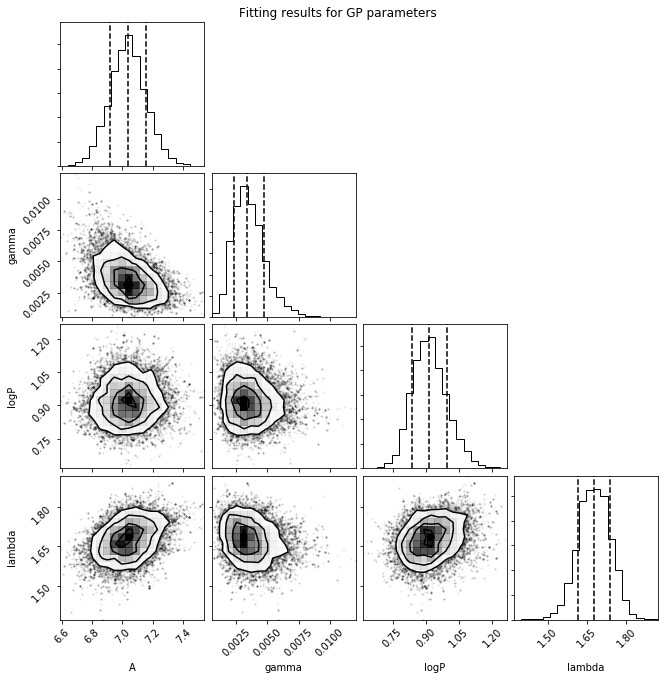

In [344]:
inds = np.array([names.index(k) for k in names[4:]])
corner.corner(sampler.flatchain[:, inds], labels=['A','gamma','logP','lambda'],quantiles=[0.16,0.50,0.84])
plt.suptitle('Fitting results for GP parameters')

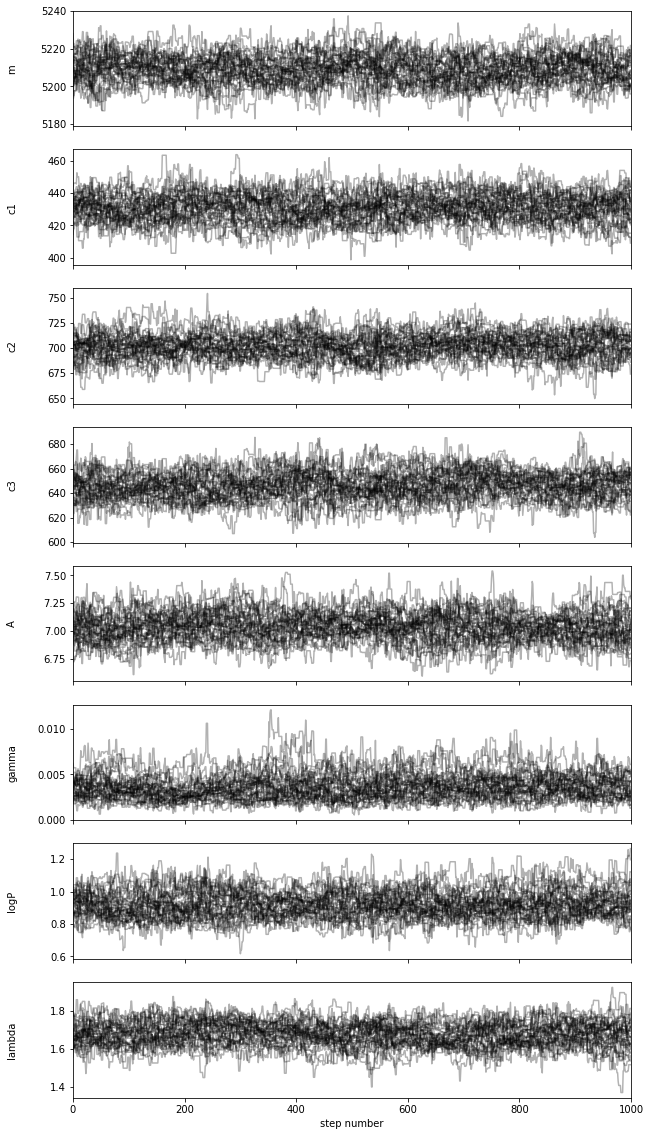

In [345]:
fig, axes = plt.subplots(nrows=8,figsize=(10,20), sharex=True)
samples = sampler.get_chain()
labels = ['m','c1','c2','c3','A','gamma','logP','lambda']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

[5.20923261e+03 4.31317597e+02 7.02048856e+02 6.46002132e+02
 7.03510700e+00 3.39532584e-03 9.13373176e-01 1.67672704e+00]


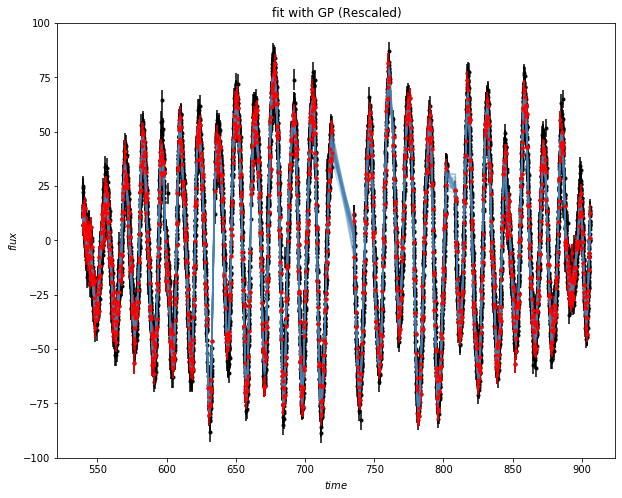

In [349]:
plt.figure(figsize=(10,8))

print (np.median(sampler.flatchain,axis=0))

m_gp, c1_gp, c2_gp, c3_gp = np.median(sampler.flatchain,axis=0)[:4]
qs = sorted(np.unique(tab['quarter']))
ff_rescale = np.copy(ff)#-m_gp
for i in range(len(qs)):
    qind = tab['quarter']==qs[i]
    tind = np.where(np.all([tt>=np.min(tab['time'][qind]),tt<=np.max(tab['time'][qind])],axis=0))[0]
    if i ==0: ff_rescale[tind] = ff_rescale[tind]-m_gp
    if i ==1: ff_rescale[tind] = ff_rescale[tind]-m_gp-c1_gp
    if i ==2: ff_rescale[tind] = ff_rescale[tind]-m_gp-c2_gp
    if i ==3: ff_rescale[tind] = ff_rescale[tind]-m_gp-c3_gp

plt.errorbar(tt[::10], ff_rescale[::10], yerr=ee[::10], fmt=".r", capsize=0)
plt.errorbar(tt, ff_rescale, yerr=ee, fmt=".k", capsize=0,zorder=-100)

# The positions where the prediction should be computed.
x = tt[::10]# np.linspace(np.min(tt), np.max(tt), len(tt[::10]))

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.sample_conditional(ff[::10],tt[::10])
    mu_rescale =  np.copy(mu)
    tmin = np.min(tt)-1
    for i in range(len(qs)):
        qind = tab['quarter']==qs[i]
        tind = np.where(np.all([x>tmin,x<=np.max(tab['time'][qind])],axis=0))[0]
        if i ==0: mu_rescale[tind] = mu_rescale[tind]-m_gp
        if i ==1: mu_rescale[tind] = mu_rescale[tind]-m_gp-c1_gp
        if i ==2: mu_rescale[tind] = mu_rescale[tind]-m_gp-c2_gp
        if i ==3: mu_rescale[tind] = mu_rescale[tind]-m_gp-c3_gp
        tmin = np.max(tab['time'][qind])
    plt.plot(x, mu_rescale, color="#4682b4", alpha=0.3)


plt.ylabel(r"$flux$")
plt.xlabel(r"$time$")
plt.ylim(-100, 100)
plt.title("fit with GP (Rescaled)");